The Idea of this script is to get the Affine invariant of each PT, and apply a discrete prpocessing to each value, in order to increase the difference of the Invaraint among each PT.

In [2]:
import pandas as pd
import numpy as np
import cv2
import math
from itertools import combinations
import os
import random
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
file_path = '/content/gdrive/MyDrive/Datos_asociacion'

In [6]:
file_list = []
for i in os.listdir(file_path):
    file_list.append(os.path.join(file_path, i))

In [7]:
file_list

['/content/gdrive/MyDrive/Datos_asociacion/IMG_0647.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0642.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0640.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0641.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0638.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0637.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0636.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0635.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0634.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0633.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0632.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0644.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_0645.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_1778.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_1779.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_1780.txt',
 '/content/gdrive/MyDrive/Datos_asociacion/IMG_1781.txt',
 '/content/gdr

In [8]:
def get_random_file():
    
    index_file = random.randint(0,len(file_list)-1)
    df_random = pd.read_table(file_list[index_file], sep = '\t', skiprows = 2)
    
    return df_random
    
# =============================================================================
# Transfer the dataframe to a appropriate form
# =============================================================================
def trans_df( df ):
    df = df.dropna(subset=["PT"])
    df = df[df.PT >= 0]
    df_trans = df[['H', 'V', 'R', 'C', 'PT']]
    df_trans['H'] = df_trans.H+2000.5
    df_trans['V'] = df_trans.V+1500.5
        
    n_marker = len(df.PT.unique())
        
    df_trans = df_trans.sort_values(by = 'PT', ascending = True)
    df_trans = df_trans.reset_index(drop = True)
        
    pointname = ['a','b','c','d']* n_marker
        
    df_trans['Point'] = pointname
    return df_trans

# =============================================================================
# Draw the markers and its invariants values
# =============================================================================
def draw_background(df):
    
    df = trans_df(df)
    newImg = np.zeros((3001, 4001, 3), np.uint8)
    newImg.fill(0)
    n_marker = df.PT.unique()
    for i in n_marker:
        listpoint = df[['H', 'V', 'R']][df.PT ==i ].values.tolist()
        for (x, y, r) in listpoint:
            cv2.circle(newImg, (int(x),int(y)), int(r), (int(i)*50, 255-50*int(i), int(i)*55), 3)
            cv2.putText(newImg, str(int(i)), (int(x),int(y)), 
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, (int(i)*50, 255-50*int(i), int(i)*50), 3)
        
    return newImg

def get_distance(point1, point2):
    return math.sqrt((point2[0]- point1[0])**2 + (point2[1]- point1[1])**2)

def get_area(side1, side2, side3):
    s = (side1+side2+side3)/2
    area = (s*(s-side1)*(s-side2)*(s-side3))**0.5
    return area

def get_affine_invariant(triangle1, triangle2):
    invariant = triangle1/triangle2
    return invariant

# =============================================================================
# generate a dataframe which contains all the line informations 
# =============================================================================
def get_df_line(df):
    n_marker = 6
    p1list = []
    p2list = []
    linename = []
    linelist = []
    box = []
    df_trans = trans_df(df)
    for i in range(n_marker):
        pointlist = df_trans [['H', 'V', 'Point']][df_trans.PT == i].values.tolist()#list to save the points under the same PT 获取各个标签下的坐标
        for j in range(len(pointlist)):
            b = [j]
            box.append(b) #Create a box to avoid calculate repeated line 每次算完一次后舍弃点，放入box内
            for k in range(len(pointlist)):
                if [k] not in box:
                    linedis = get_distance(pointlist[j], pointlist[k])
                    point1 = pointlist[j][2]
                    point2 = pointlist[k][2]
                    line12 = point1+point2
                    PT_1 = i
                    dat = [linedis, PT_1]
                    p1list.append(point1)
                    p2list.append(point2)
                    linename.append(line12)

                    linelist.append(dat)
                
        box = []
        
    df_line = pd.DataFrame()
    df_line[['Dis', 'PT']] = linelist
    df_line['P1']= p1list
    df_line['P2']= p2list
    df_line['Line'] = linename
    return df_line


Choose 6 samples and 1 random sample for comparasion

In [9]:
marker_point = ['a', 'b', 'c', 'd']
com_triangle = list(combinations(marker_point, 3))

df1 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_2922.txt', sep = '\t', skiprows = 2)
df2 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_2968.txt', sep = '\t', skiprows = 2)
df3 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_2974.txt', sep = '\t', skiprows = 2)
df4 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_3011.txt', sep = '\t', skiprows = 2)
df5 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_3030.txt', sep = '\t', skiprows = 2)
df6 = pd.read_table('/content/gdrive/MyDrive/Datos_asociacion/IMG_3047.txt', sep = '\t', skiprows = 2)
df_random = get_random_file()


Each PT has 4 points, here is to get the all possible 4 triangle combinations with diffrent combinations of three points, and calculate the area of these 4 triangles.


In [10]:
def get_combination_area(df):
    df = df.dropna(subset=["PT"])
    df = df[df.PT >= 0]
    df_trans = trans_df(df)
    df_line = get_df_line(df)
    n_marker = df.PT.unique()
    l = []
    l2 = []
    for i in n_marker:
        line = df_line[df_line.PT == i ]
        trans = df_trans[df_trans.PT == i]
        
        for j in range(len(com_triangle)):
            point1 = com_triangle[j][0]
            point2 = com_triangle[j][1]
            point3 = com_triangle[j][2]
            
            x1 = float(trans.H[trans.Point == point1])
            y1 = float(trans.V[trans.Point == point1])
            
            x2 = float(trans.H[trans.Point == point2])
            y2 = float(trans.V[trans.Point == point2])
            
            x3 = float(trans.H[trans.Point == point3])
            y3 = float(trans.V[trans.Point == point3])
            
            area_tran = 0.5*abs(x2*y3 +x1*y2 +x3*y1 -x3*y2 - x2*y1 -x1*y3)
            PT = i
            dat = [area_tran, PT]
            dat2 = [point1, point2, point3]
            l.append(dat)
            l2.append(dat2)
        
    df_final = pd.DataFrame()
    df_final[['Area', 'PT']] = l
    df_final[['Point1', 'Point2', 'Point3']] = l2
    
    return df_final

df_area1 = get_combination_area(df1)
df_area2 = get_combination_area(df2)
df_area3 = get_combination_area(df3)
df_area4 = get_combination_area(df4)
df_area5 = get_combination_area(df5)
df_area6 = get_combination_area(df6)
df_area_random = get_combination_area(df_random)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


get the second largest triangle


In [11]:
def get_second_largest(df):
    
    sort_set = df['Area'].values.tolist()
    sort_value = sorted(sort_set, reverse = True)[1]
    temp_df = df[df['Area'] == sort_value]
    return temp_df

get the largest triangle


In [12]:
def get_the_largest(df):
    
    sort_set = df['Area'].values.tolist()
    sort_value = sorted(sort_set, reverse = True)[0]
    temp_df = df[df['Area'] == sort_value]
    return temp_df


In each PT there are 4 triangles, here we choose the 2 of them which have the biggest and the second biggest area.

In [13]:


    
df_largest_1 = df_area1.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_1 = df_area1.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)
    
df_largest_2 = df_area2.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_2 = df_area2.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)
    
df_largest_3 = df_area3.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_3 = df_area3.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)
    
df_largest_4 = df_area4.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_4 = df_area4.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)
    
df_largest_5 = df_area5.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_5 = df_area5.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)
    
df_largest_6 = df_area6.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_6 = df_area6.groupby(by = ['PT']).apply(get_second_largest).reset_index(drop = True)

df_largest_random = df_area_random.groupby(by = ['PT']).apply(get_the_largest).reset_index(drop = True)
df_second_random = df_area_random.groupby( by = ['PT']).apply(get_second_largest).reset_index(drop = True)




df_two_largest_1 = df_largest_1.append(df_second_1)
df_two_largest_1 = df_two_largest_1.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_2 = df_largest_2.append(df_second_2)
df_two_largest_2 = df_two_largest_2.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_3 = df_largest_3.append(df_second_3)
df_two_largest_3 = df_two_largest_3.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_4 = df_largest_4.append(df_second_4)
df_two_largest_4 = df_two_largest_4.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_5 = df_largest_5.append(df_second_5)
df_two_largest_5 = df_two_largest_5.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_6 = df_largest_6.append(df_second_6)
df_two_largest_6 = df_two_largest_6.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

df_two_largest_random = df_largest_random.append(df_second_random)
df_two_largest_random = df_two_largest_random.groupby('PT').apply(lambda x: x.sort_values('Area', ascending = False)).reset_index(drop = True)

In each Dataframe df_two_largest_n contains the 2 biggest triangle information in each PT, their areas and the points that consist these 2 triangles.

In [14]:
df_two_largest_1

,Area,PT,Point1,Point2,Point3
0,6494.017815,0.0,a,c,d
1,5323.726139,0.0,b,c,d
2,6894.670788,1.0,a,b,d
3,6388.810004,1.0,a,b,c
4,7848.685893,2.0,a,b,d
5,5234.604856,2.0,b,c,d
6,7815.433255,3.0,a,c,d
7,6252.671914,3.0,a,b,d
8,9431.841884,4.0,b,c,d
9,4362.026945,4.0,a,b,d


Calculate the Invariants bwtween these 2 triangles and Visualize them 

In [15]:
def get_invariante_and_IMG(df, df_two_largest,d): 
    
    df_trans = trans_df(df)
    green = (0,255,0)
    red = (0,0,255)
    invariant = []
    invariant_dis = []
    point = []
    n_marker = df_trans.PT.unique()
    IMG = draw_background(df)
    for i in n_marker:
        area_list = df_two_largest[df_two_largest.PT == i].values.tolist()
        affine = area_list[0][0]/area_list[1][0]
        discrete = round(affine**10, d)
        

        
        point_list = df_two_largest[['Point1', 'Point2', 'Point3']][df_two_largest.PT == i].values.tolist()
        invariant.append(affine)
        invariant_dis.append(discrete)
        point_list2 = [point_list[0][0], point_list[0][1], point_list[0][2],
                       point_list[1][0], point_list[1][1], point_list[1][2]]
        point.append(point_list2)
        
        
        df_trans_PT = df_trans[df_trans.PT == i]
        
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[0]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[0]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[1]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[1]])), green, 3)
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[0]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[0]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[2]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[2]])), green, 3)
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[2]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[2]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[1]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[1]])), green, 3)
        
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[3]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[3]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[4]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[4]])), red, 3)
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[3]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[3]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[5]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[5]])), red, 3)
        cv2.line(IMG, (int(df_trans_PT.H[df_trans_PT.Point == point_list2[4]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[4]])),
                 (int(df_trans_PT.H[df_trans_PT.Point == point_list2[5]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[5]])), red, 3)
        
        cv2.putText(IMG, str(discrete), (int(df_trans_PT.H[df_trans_PT.Point == point_list2[0]]), int(df_trans_PT.V[df_trans_PT.Point == point_list2[0]]-200)),
            cv2.FONT_HERSHEY_COMPLEX, 2.0, (100,200,200), 3)
    
    df_invariant = pd.DataFrame()
    df_invariant['Cross_ratio'] = invariant
    df_invariant['Discrete'] = invariant_dis
    df_invariant[['Point1', 'Point2', 'Point3', 'Point4', 'Point5', 'Point6']] = point
    
    return df_invariant, IMG

In [16]:

d = 2

df_invariant1, IMG1 = get_invariante_and_IMG(df1, df_two_largest_1, d)
df_invariant2, IMG2 = get_invariante_and_IMG(df2, df_two_largest_2, d)
df_invariant3, IMG3 = get_invariante_and_IMG(df3, df_two_largest_3, d)
df_invariant4, IMG4 = get_invariante_and_IMG(df4, df_two_largest_4, d)
df_invariant5, IMG5 = get_invariante_and_IMG(df5, df_two_largest_5, d)
df_invariant6, IMG6 = get_invariante_and_IMG(df6, df_two_largest_6, d)
df_invariantrandom, IMGrandom = get_invariante_and_IMG(df_random, df_two_largest_random, d)
    




    
    

    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [28]:
df_invariantrandom

,Cross_ratio,Discrete,Point1,Point2,Point3,Point4,Point5,Point6
0,1.218998,7.24,a,b,d,b,c,d
1,1.501244,58.15,a,b,c,a,c,d
2,1.253321,9.56,b,c,d,a,c,d
3,1.241929,8.73,a,b,d,a,c,d
4,1.062385,1.83,a,b,d,a,c,d


Dont run this code on google colab, doesn't work in jupyternotebook, only for spyder 

In [27]:
#cv2.namedWindow('1', cv2.WINDOW_NORMAL)
#cv2.imshow('1', IMG1)
#cv2.namedWindow('2', cv2.WINDOW_NORMAL)
#cv2.imshow('2', IMG2)
#cv2.namedWindow('3', cv2.WINDOW_NORMAL)
#cv2.imshow('3', IMG3)
#cv2.namedWindow('4', cv2.WINDOW_NORMAL)
#cv2.imshow('4', IMG4)
#cv2.namedWindow('5', cv2.WINDOW_NORMAL)
#cv2.imshow('5', IMG5)
#cv2.namedWindow('6', cv2.WINDOW_NORMAL)
#cv2.imshow('6', IMG6)
#cv2.namedWindow('random', cv2.WINDOW_NORMAL)
#cv2.imshow('random', IMGrandom)


#for jupyternotebook:

In [18]:
from google.colab.patches import cv2_imshow

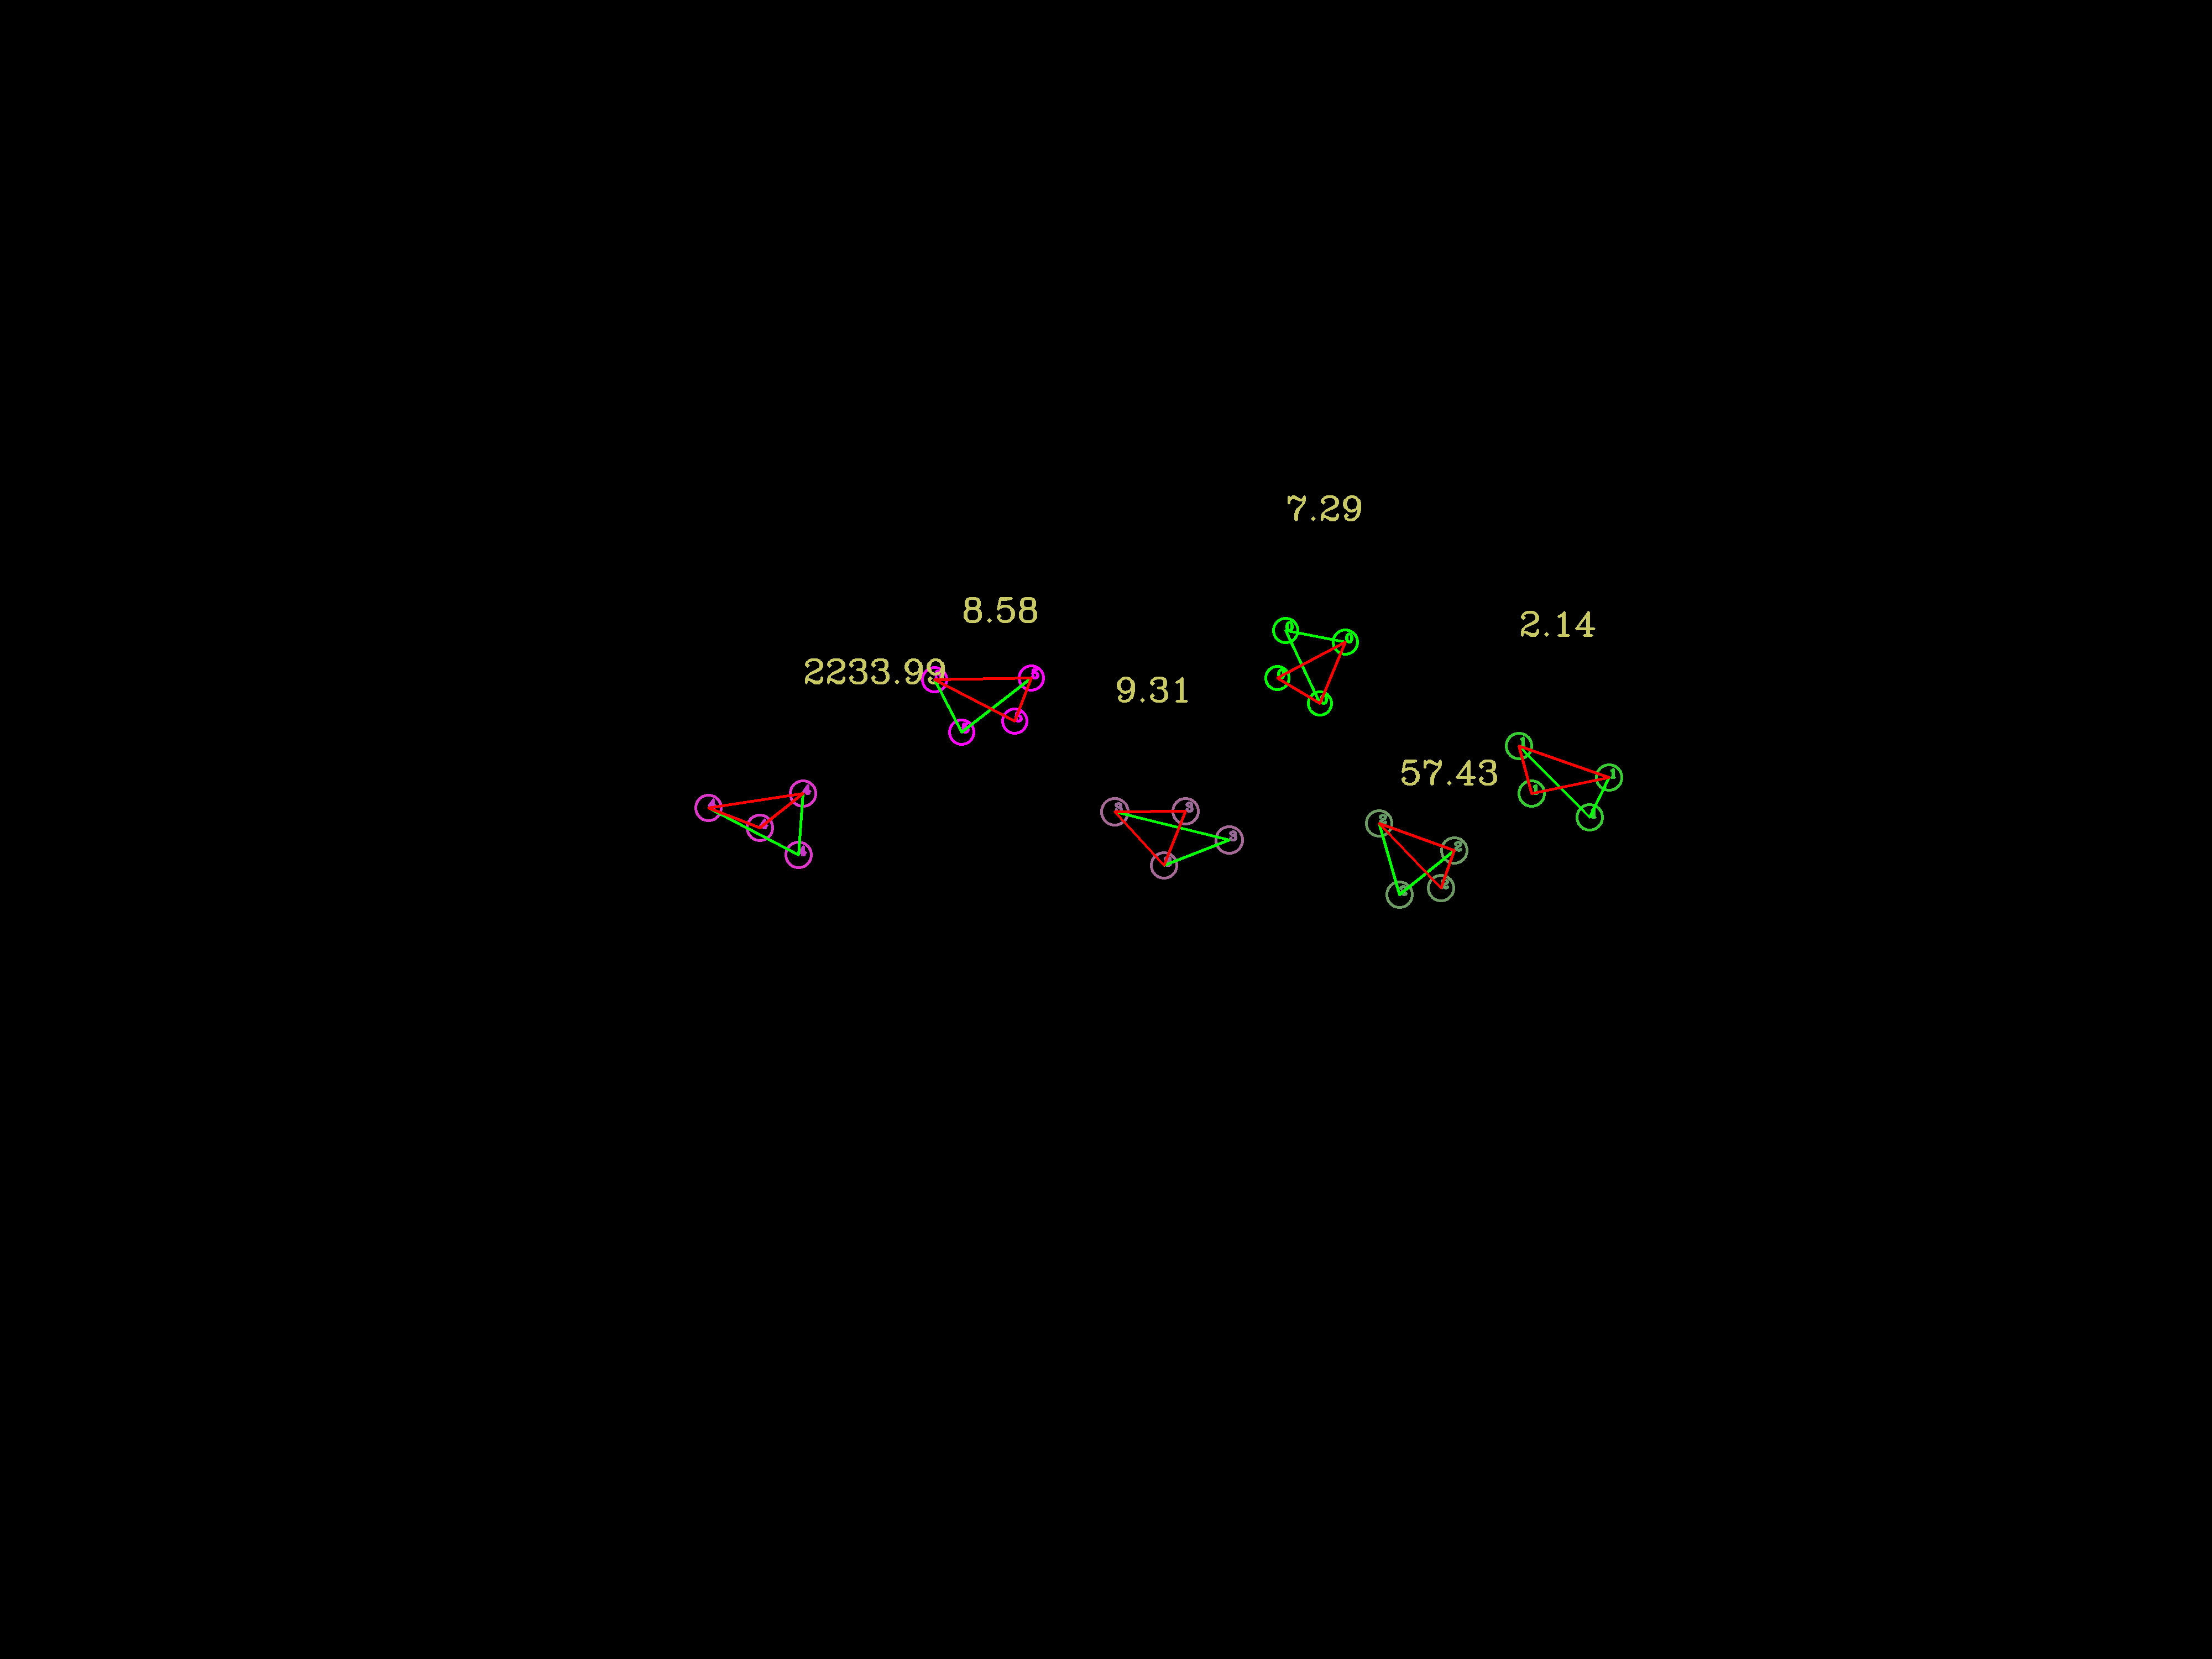

In [20]:
cv2_imshow( IMG1)

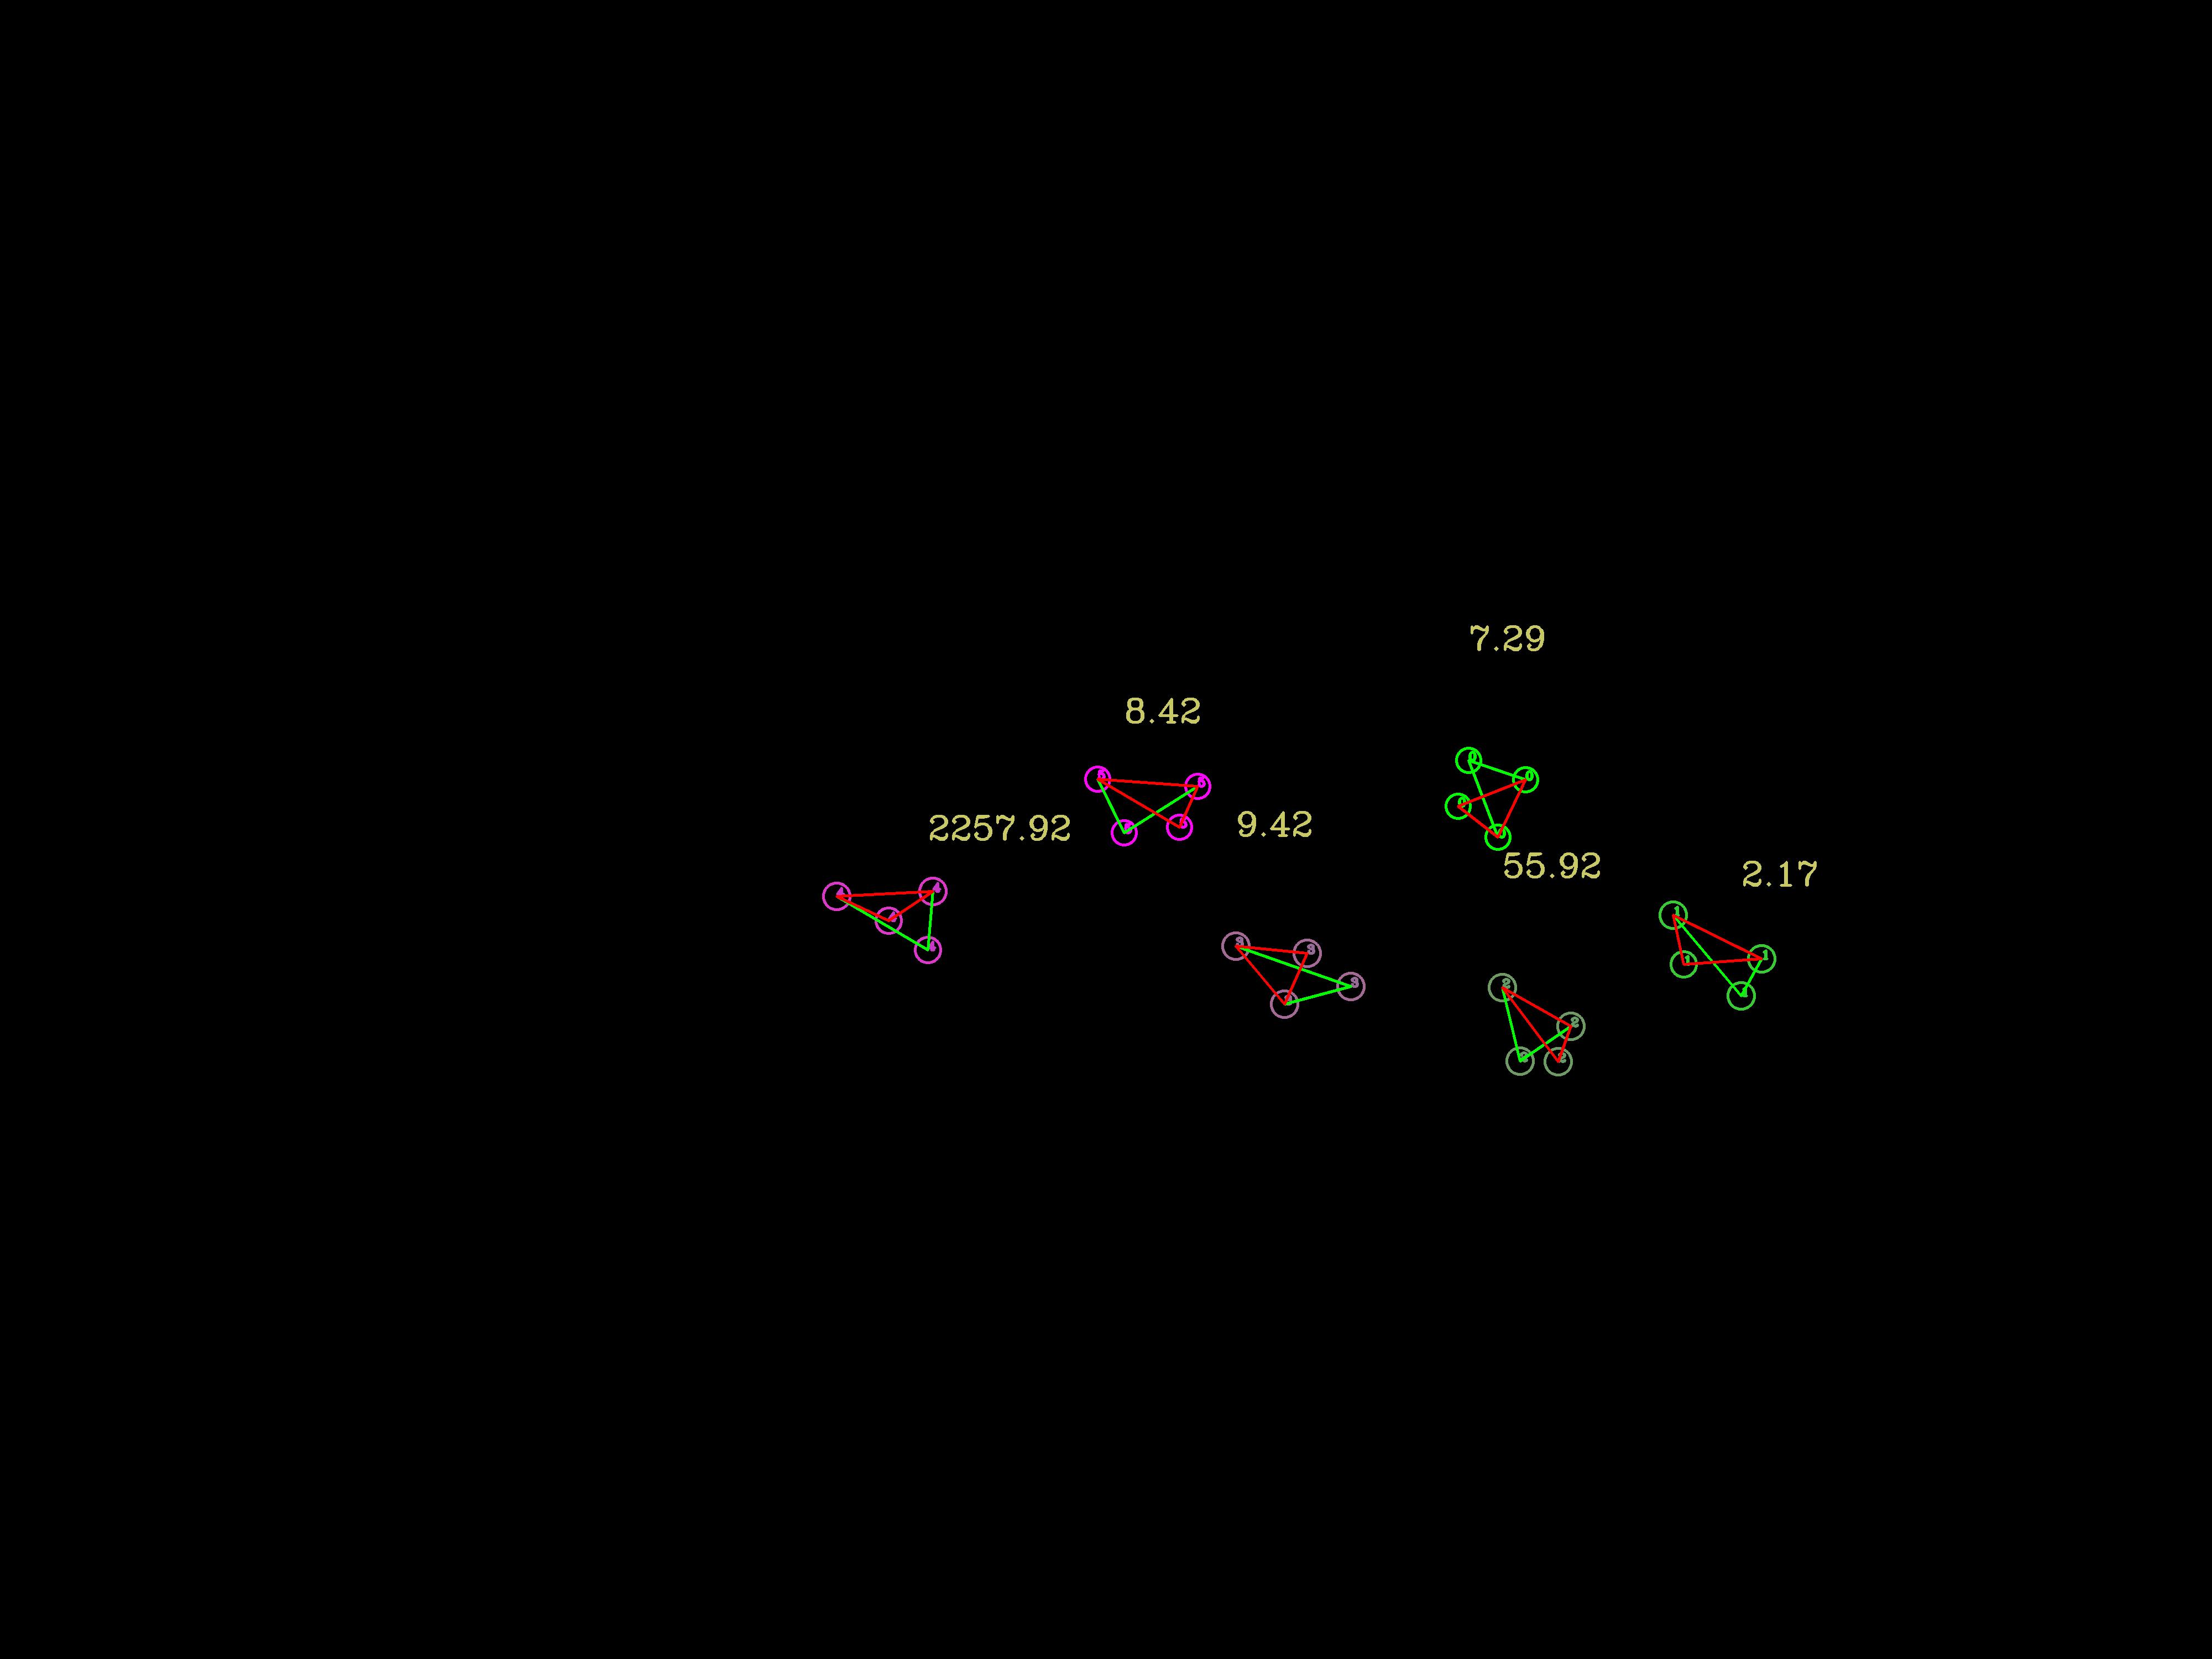

In [21]:
cv2_imshow( IMG2)

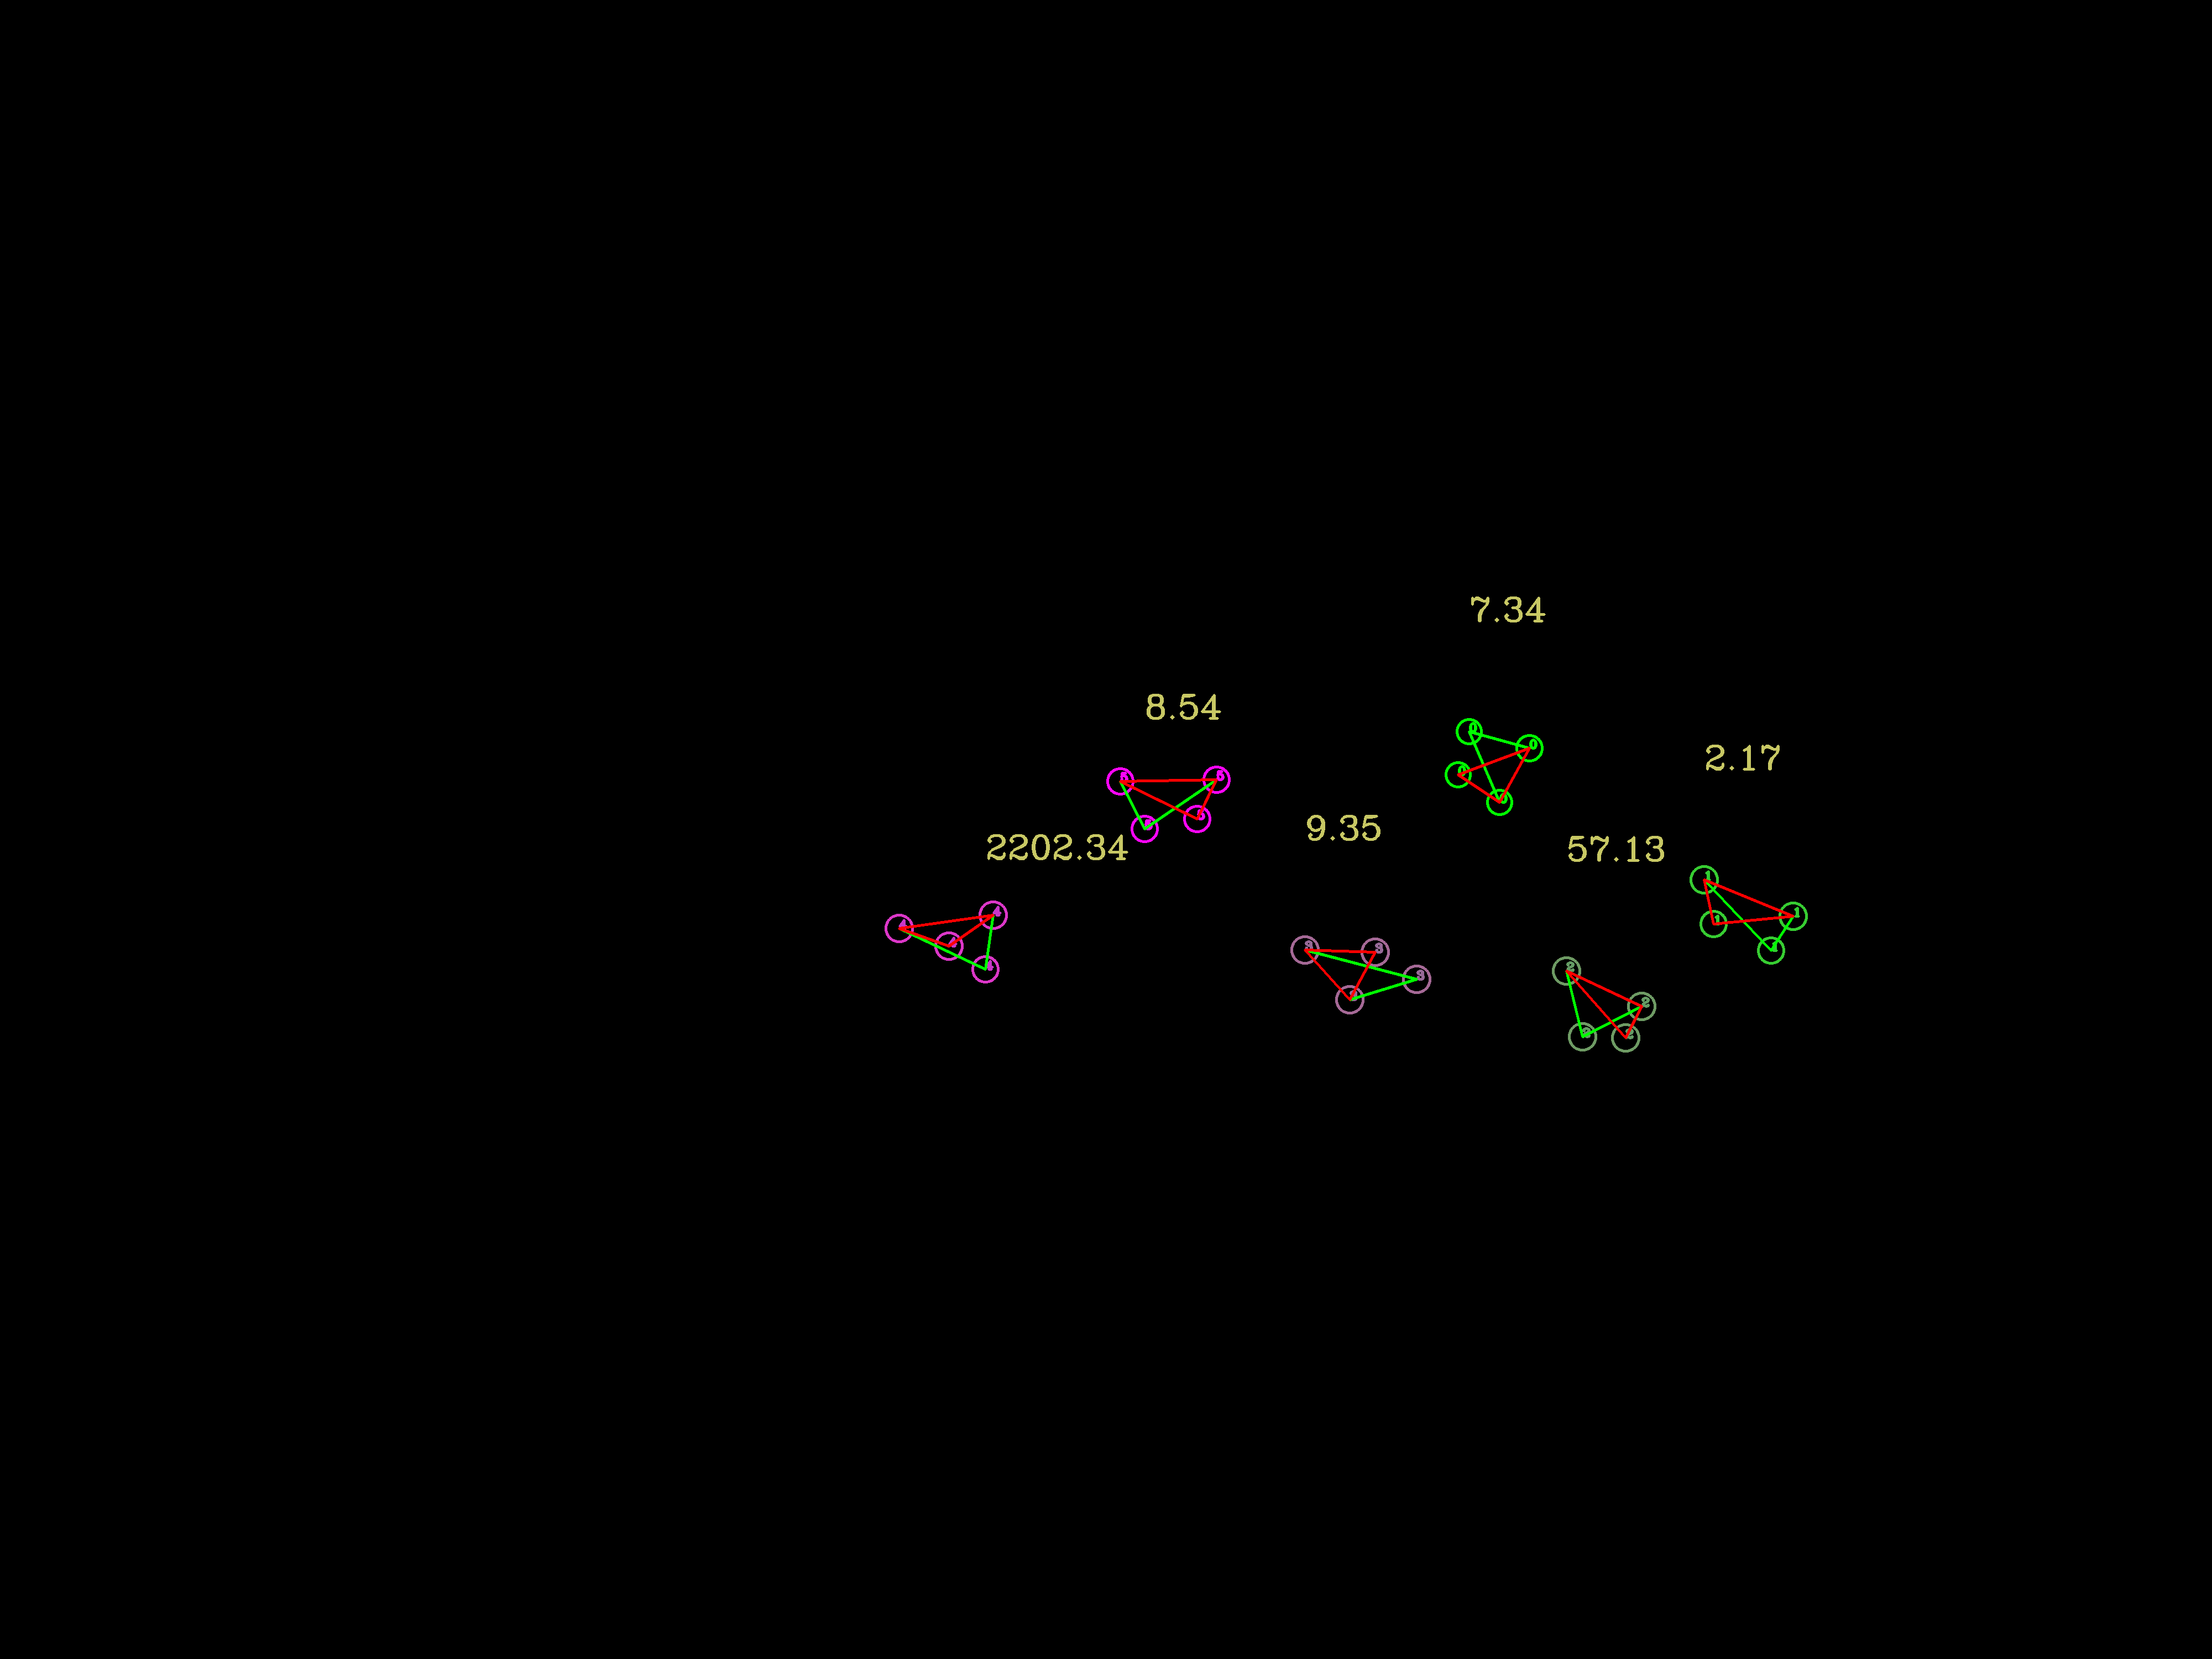

In [22]:
cv2_imshow( IMG3)

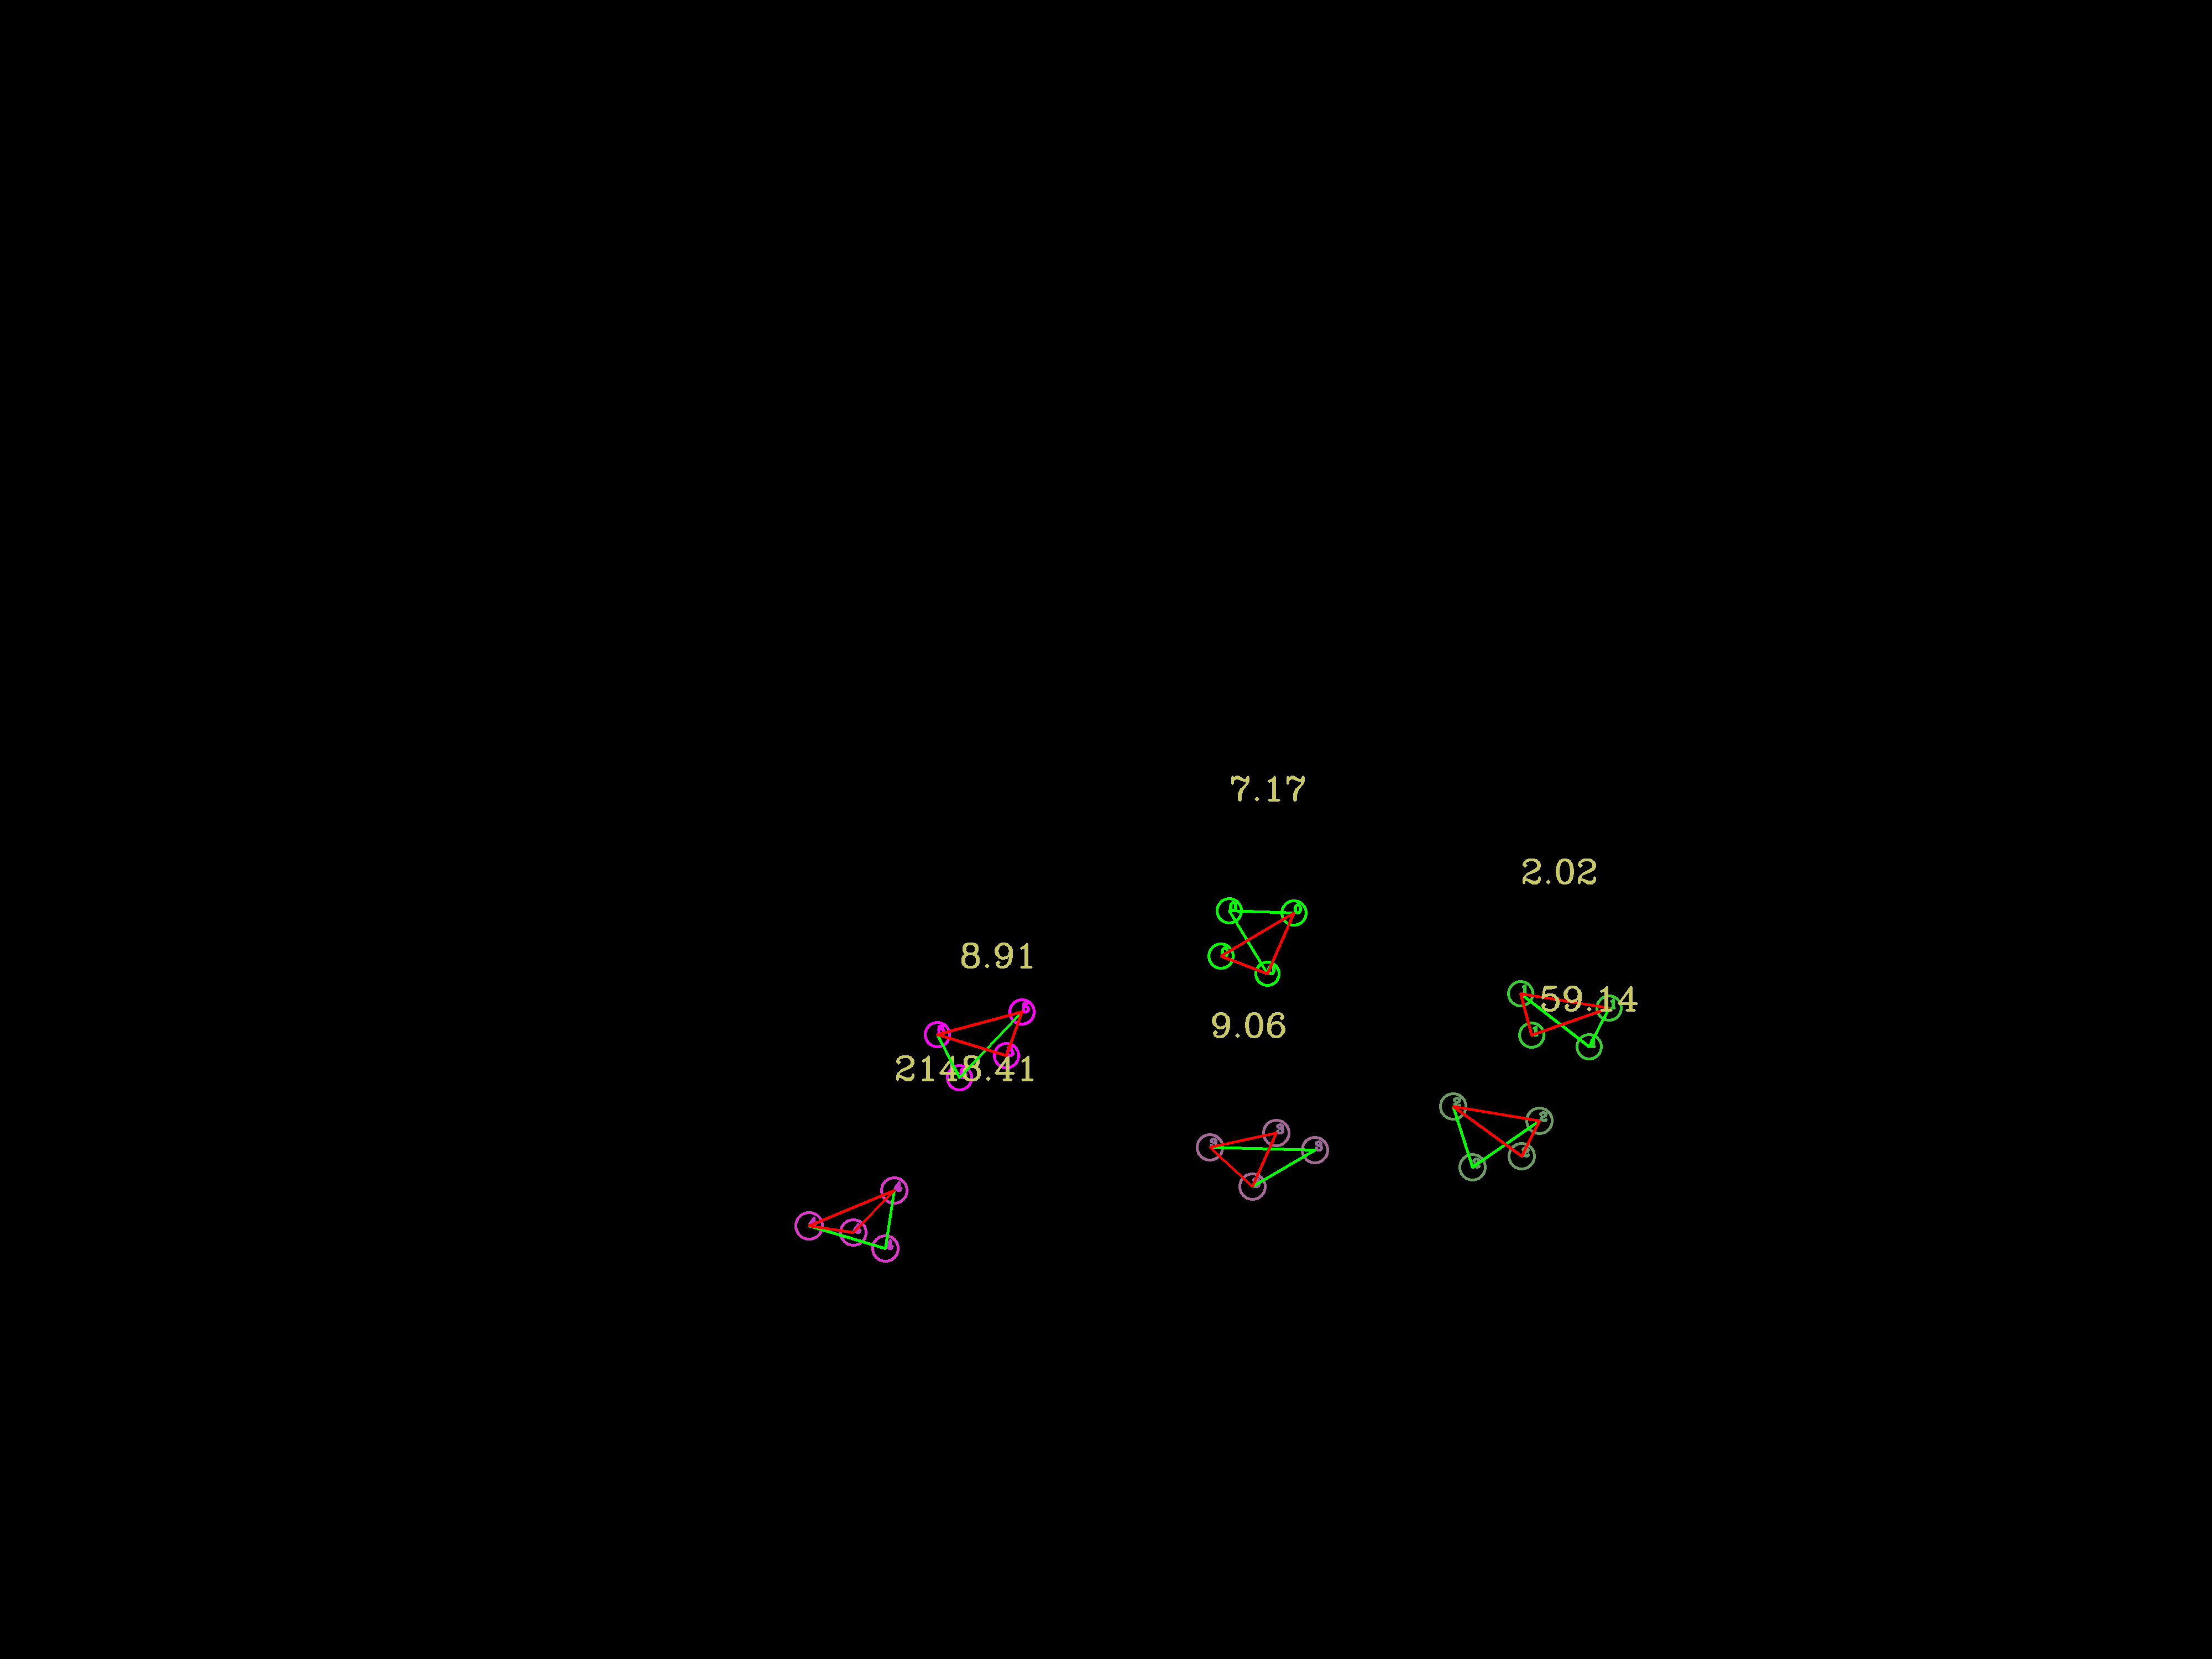

In [23]:
cv2_imshow( IMG4)

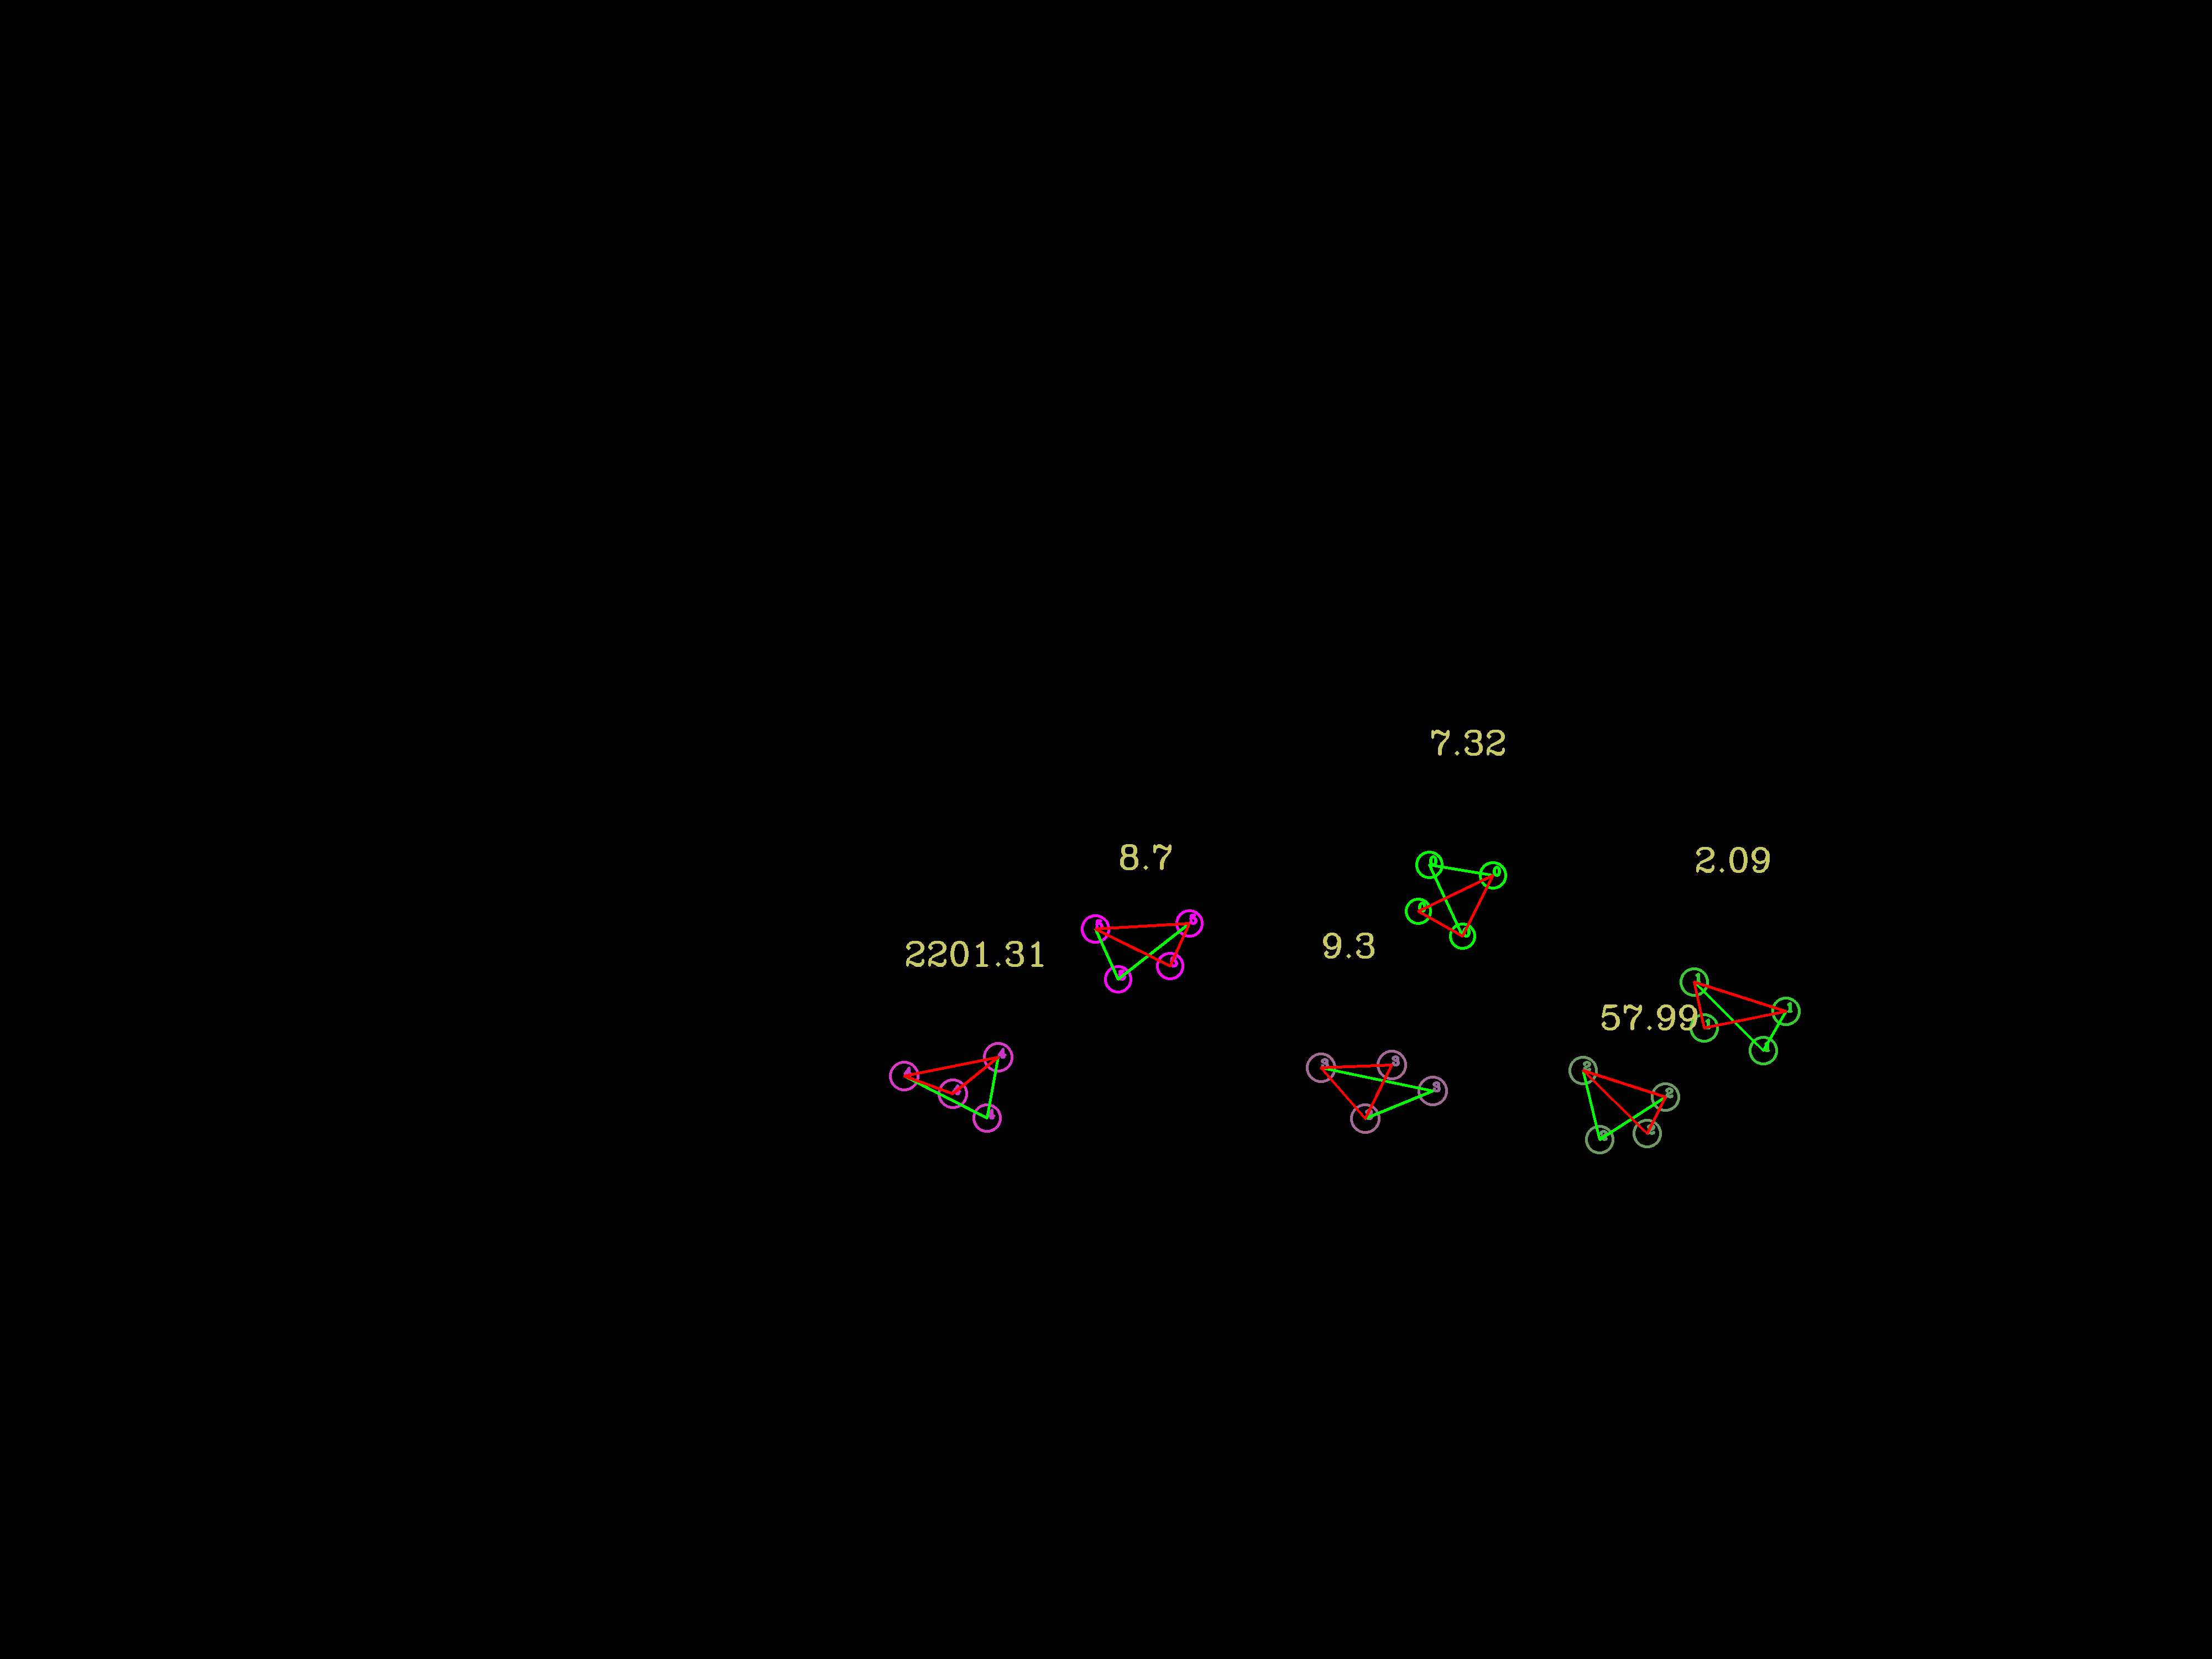

In [24]:
cv2_imshow( IMG5)

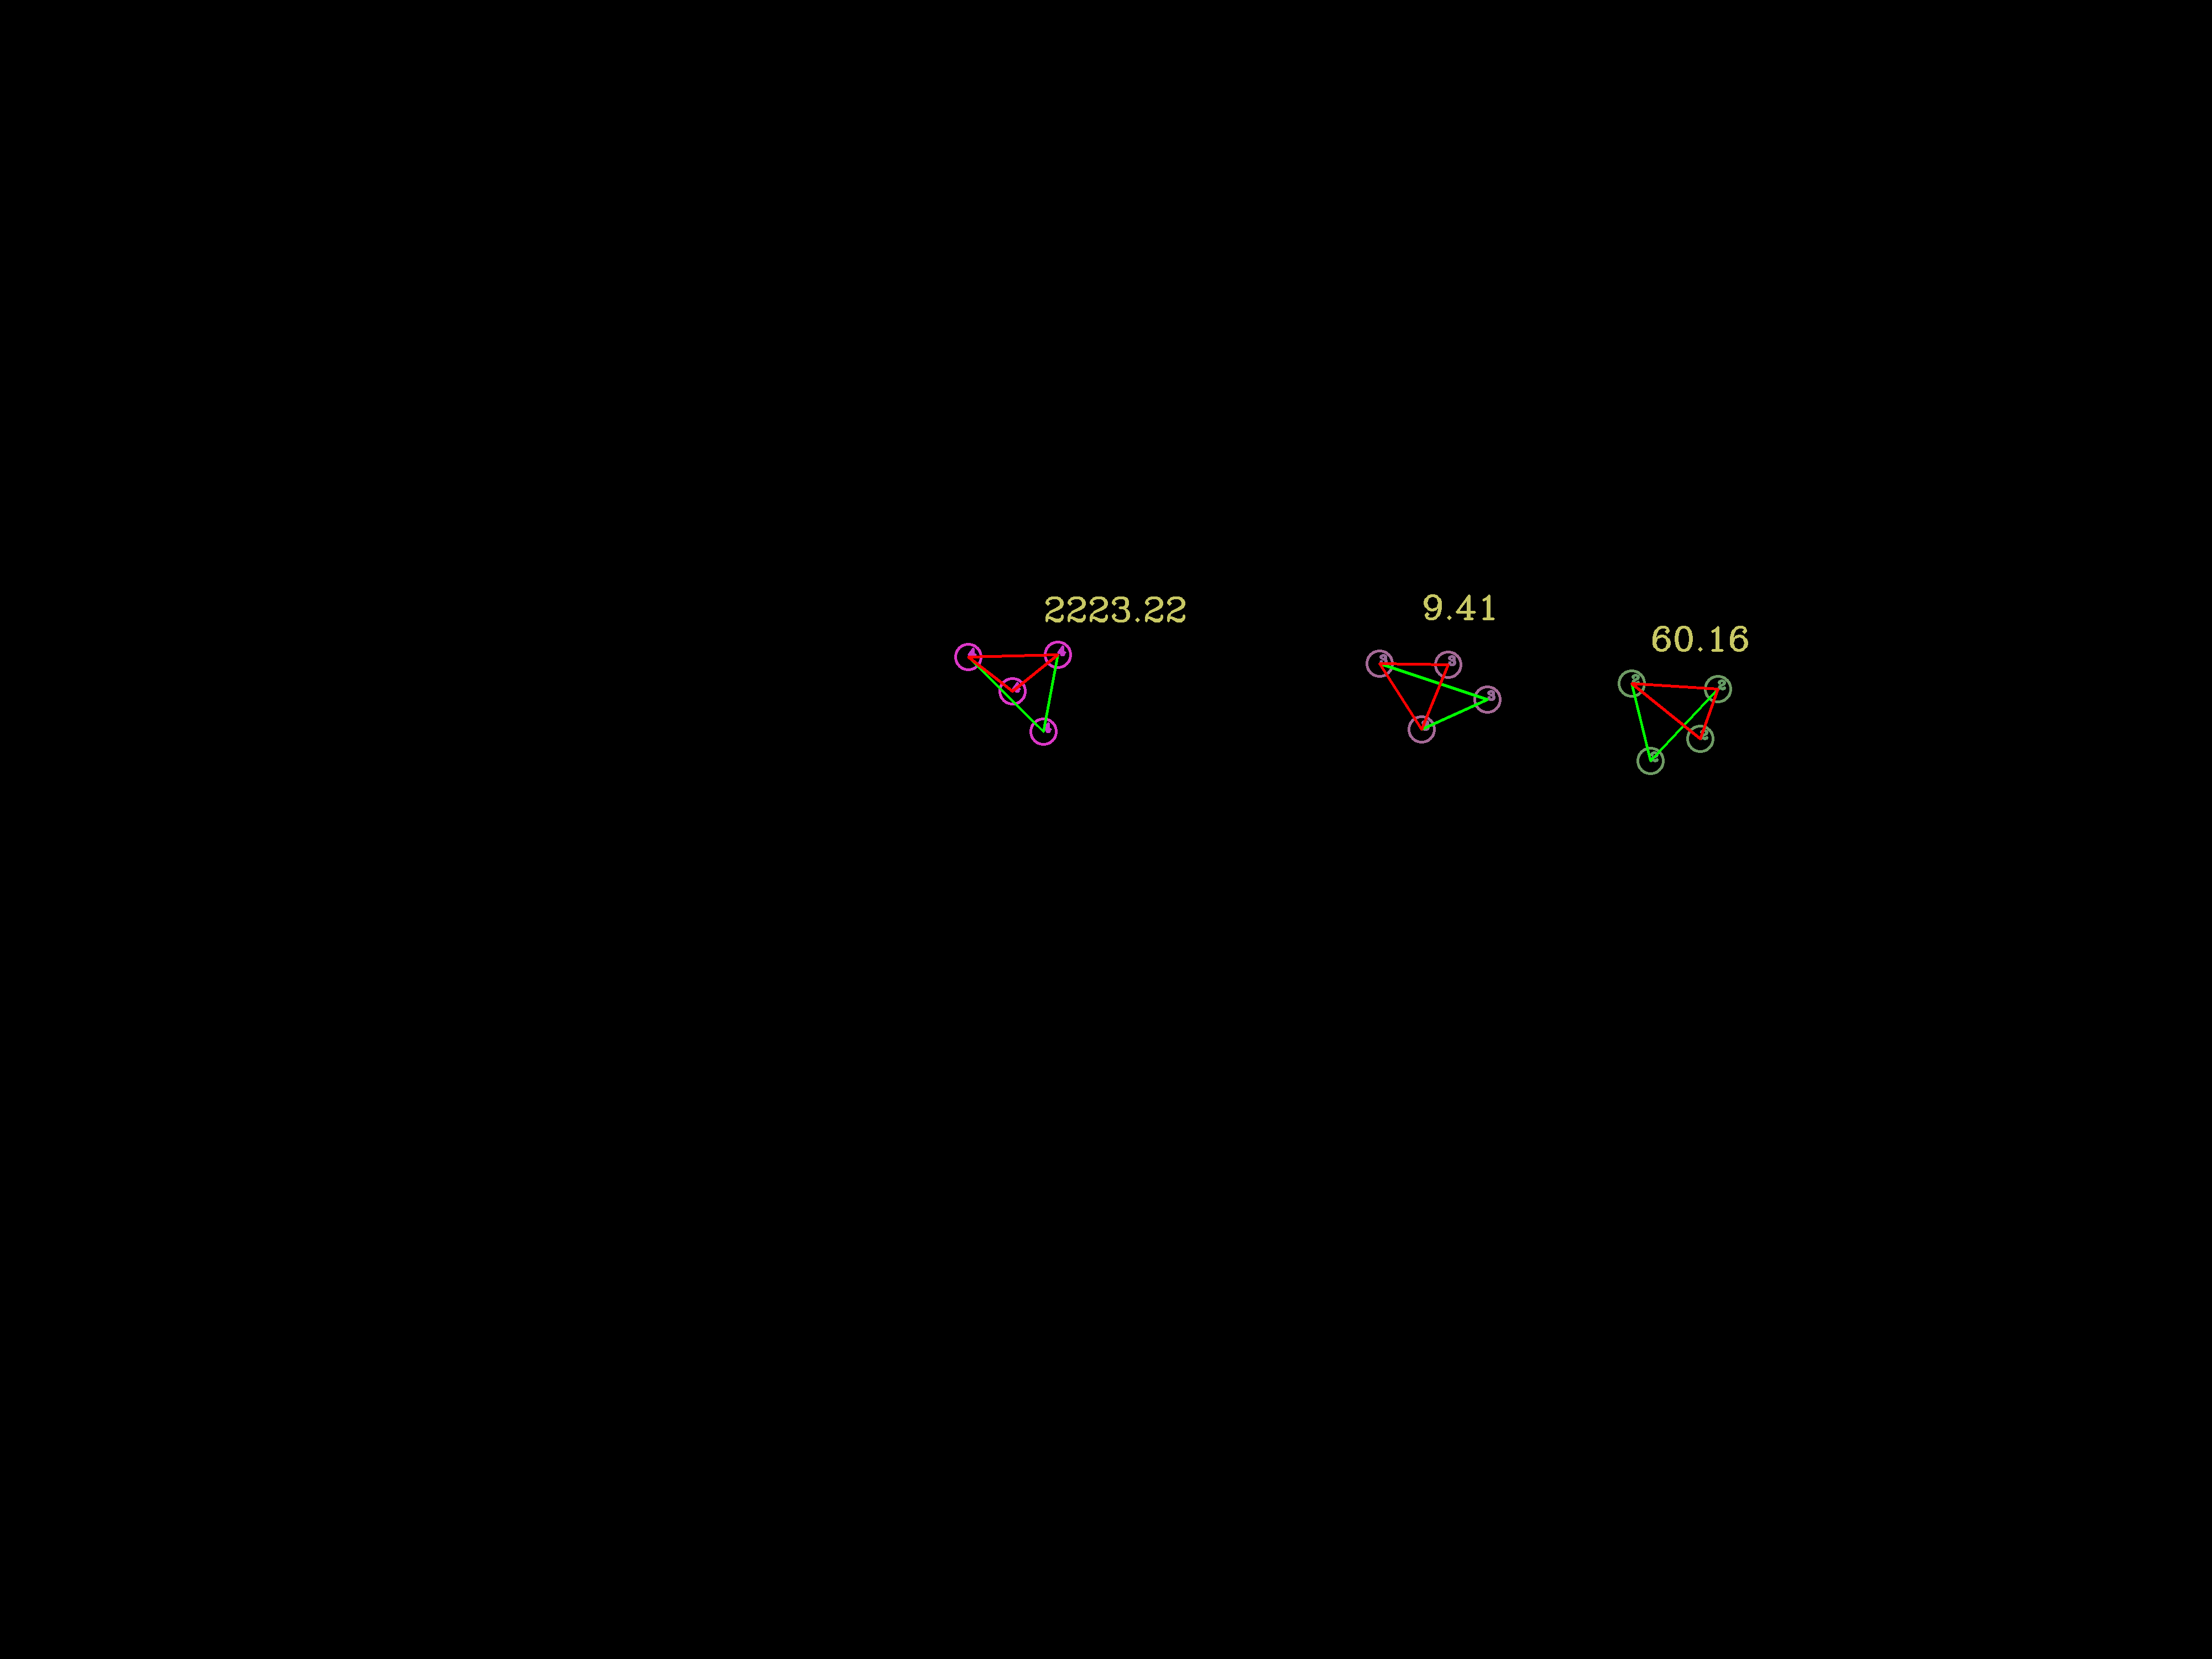

In [25]:
cv2_imshow( IMG6)

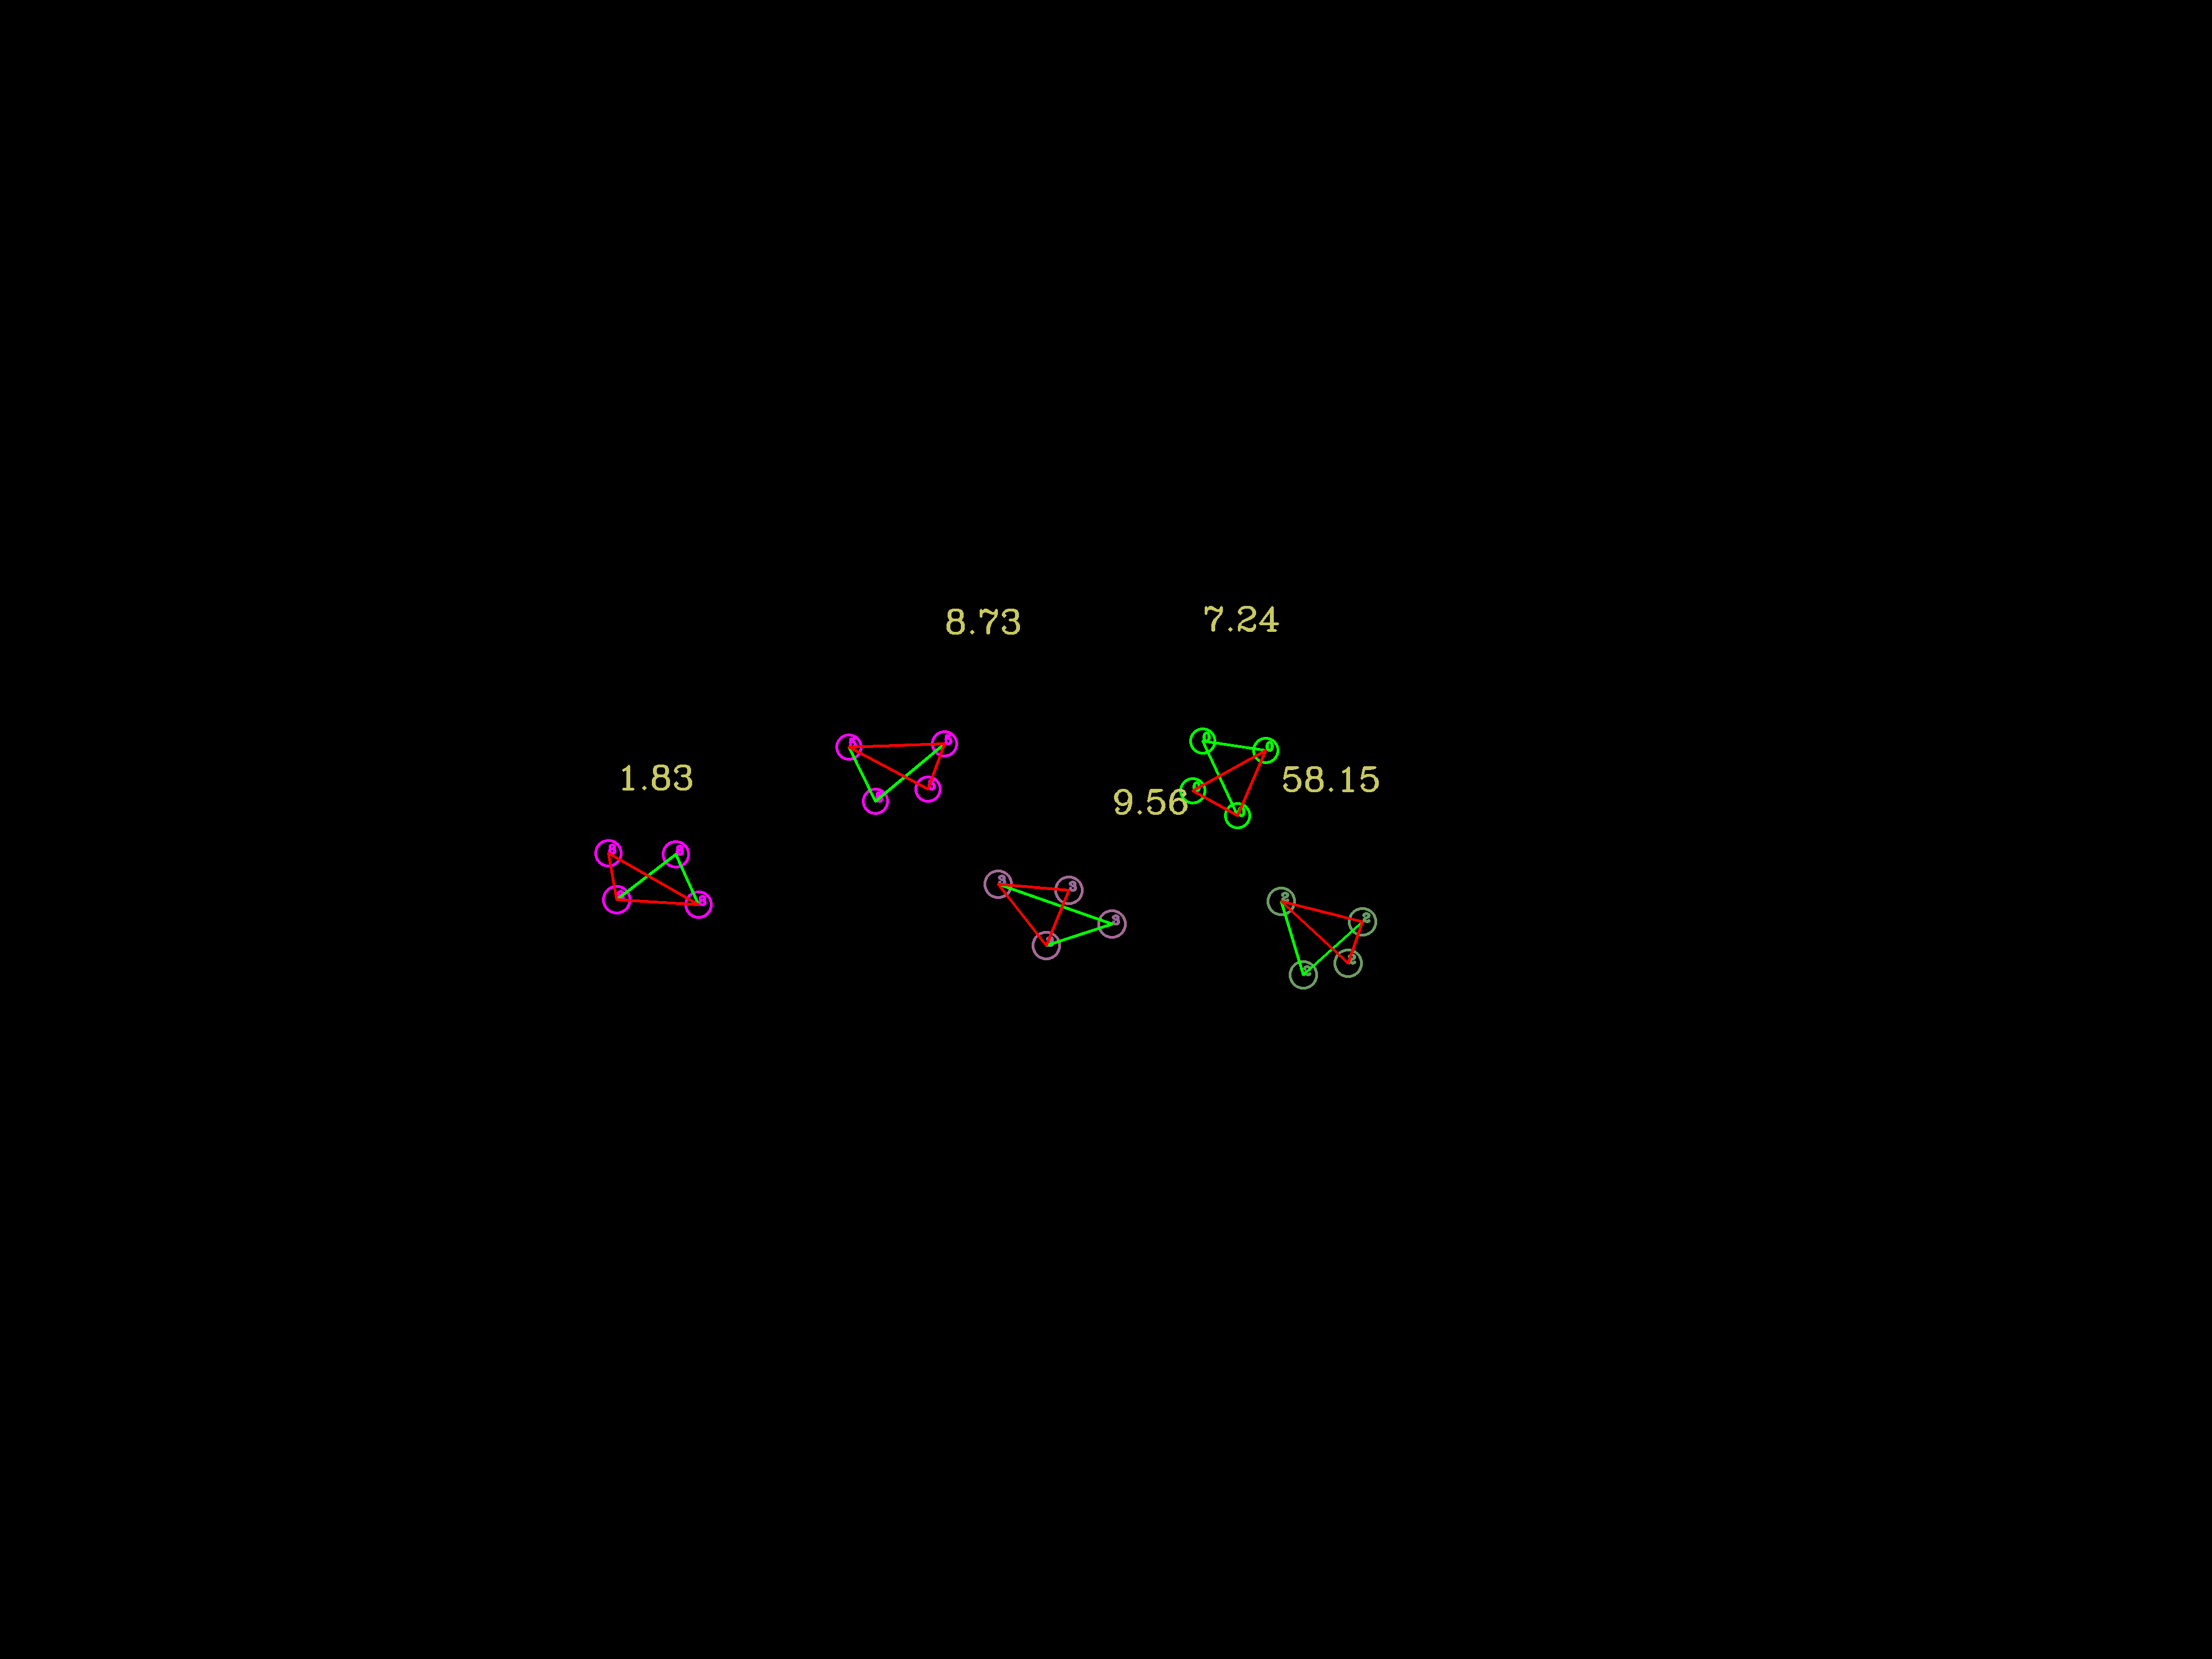

In [26]:
cv2_imshow( IMGrandom)

#ConConclusion

The idea was, since all the PT has similar Affine Invariant values, the idea was to get a more discrete value by using each invariant value ** 10. 

However,as we can see in the images, after applying the discreting process, in different images, the Invariants of the same PT are not exactly the same values, not even similar. So this idea is denied.